## Bistable Solution as found in 2016 paper by Sharma and Roberts

In [1]:
# import modules
%reset
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.integrate as snt
import scipy.stats as stats
from scipy.optimize import curve_fit
import os
import plotly.plotly as py
import plotly.graph_objs as go
from decimal import Decimal
from matplotlib.colors import LogNorm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
## define constants and model

## SPECIES
    # S (singal ~alpha factor)
    # K (kinase in MAPK pathway)
    # Kp (singly phosphorylated kinase)
    # Kpp (doubly phosphorylated kinase)
    # P (phosphatase to remove phosphates from kinases)
# mass balance laws:
    # Ktot = K + Kp + Kpp
    
## REACTIONS
    # S + K -> Kp + S            c0
    # K + K -> Kp + K           2c1
    # K + Kp -> Kp + Kp         2c2
    # Kp + Kp -> Kpp + Kp        c2
    # Kp + Kpp -> Kpp + Kpp      c3
    # K + Kpp -> Kpp + Kp       2c3
    # Kpp + P -> Kp + P         2c4
    # Kp + P -> K + P            c4
    # *****************************
    # K + Kp -> Kpp + K (c1) and other permutations of the kinase autophorylation were neglected for simplicity
    # *****************************

## KINETIC RATE LAWS
    # dK/dt   = -c0*S*K - 2*c1*K**2 - 2*c2*K*Kp - 2*c3*K*Kpp + c4*Kp*P
    # dKp/dt  = c0*S*K + 2*c1*K**2 + 2*c2*Kp*K - c2*Kp**2 - c3*Kp*Kpp + 2*c3*Kpp*K + 2*c4*Kpp*P - c4*Kp*P
    # dKpp/dt = c2*Kp**2 + c3*Kpp*Kp - 2*c4*Kpp*P

# DEFINE CONSTANTS
Ktot = 1
P = 0.25

    
## DEFINE RATES THAT ARE NOT BEING VARIED
c0 = 0.1
c3 = 5
c4 = 5

## DEFINE RANGE AT WHICH OTHER RATES MAY VARY
n = 100
rateRange = np.linspace(0, max([c0, c3, c4]), n)

## reaction matrix
    #        S*K   K**2   K*Kp   Kp*Kp  Kp*Kpp   K*Kpp   Kpp*P   Kp*P
    # K      -c0   -2c1   -2c2     0      0      -2c3      0      c4
    # Kp      c0    2c1    2c2    -c2    -c3      2c3     2c4    -c4
    # Kpp     0      0      0      c2     c3       0     -2c4     0
    
## define ODEs
def rates(y, t, c0, c1, c2, c3, c4, S, P):
    return np.asarray([-c0*S*y[0] - 2*c1*y[0]**2 - 2*c2*y[0]*y[1] - 2*c3*y[0]*y[2] + c4*y[1]*P,
                      c0*S*y[0] + 2*c1*y[0]**2 + 2*c2*y[1]*y[0] - c2*y[1]**2 - c3*y[1]*y[2] + 2*c3*y[2]*y[0] + 2*c4*y[2]*P - c4*y[1]*P,
                      c2*y[1]**2 + c3*y[2]*y[1] - 2*c4*y[2]*P])

In [3]:
# filename for parameter trials
paramFile = "parameterMatrix.dat"
odeFile = "parameterTrial.dat"

params = {}

#there should be paramRange^params columns so in our case len(paramRange)^nReac
cols = len(rateRange)**2 # since we are only varying 2 rates

params['c0'] = np.ones(cols)*c0
params['c1'] = np.zeros(cols)
params['c2'] = np.zeros(cols)
params['c3'] = np.ones(cols)*c3
params['c4'] = np.ones(cols)*c4

keys = ['c0', 'c1', 'c2', 'c3', 'c4']

In [4]:
# check to see if there are parameter files to avoid having to run the next section
files = os.listdir(".")
if paramFile not in files:
    print("the parameter permutations have not been created"
          "\nthis may take a bit of time dependent on the given parameter range")
    runPerm = True
else:
    print('the parameter permutations have already been created')
    runPerm = False
    FID = open(paramFile, 'r')
    data = FID.readlines()
    for i in range(len(data)):
        data[i] = data[i].strip()
        data[i] = data[i].split()
        for j in range(len(keys)):
            params[keys[j]][i] = float(data[i][j])
    #close file now that data has been read in
    FID.close()
    print('parameter file read in')

the parameter permutations have already been created
parameter file read in


In [5]:
# the first parameter is the longest to set up, time improves for each successive parameter
if runPerm:
    iter = 0
    for par in [1, 2]:
        indStart = 0
        while indStart < cols:
            val = 0
            while val < len(rateRange):
                indEnd = indStart + len(rateRange)**(iter)
                params[keys[par]][indStart:indEnd] = rateRange[val]
                val += 1
                indStart = indEnd
        iter = iter + 1
    #save permutations file to avoid having to run the above code more than once
    print('writing parameters to file to avoid having to run again')
    FID = open(paramFile, 'w')
    for i in range(len(params['c0'])):
        line = [];
        for j in range(len(keys)):
            line.append(str(params[keys[j]][i]))
        FID.write(' '.join(line))
        FID.write('\n')
    #close file now that data has been read in
    FID.close()
    print('done')


In [60]:
tol = 1e-4
Ktot = 1
S = 1
Kp = np.linspace(0,Ktot,float(n)/2)
Kpp = np.linspace(0,Ktot,float(n)/2)

diff = {}
acc = 0
for iter in range(len(params['c0'])):
    c0 = params['c0'][iter]
    c1 = params['c1'][iter]
    c2 = params['c2'][iter]
    c3 = params['c3'][iter]
    c4 = params['c4'][iter]
    #append to differential space
    A = np.matrix(np.asarray([
                -c0, -2*c1, -2*c2,   0,   0, -2*c3,    0,  c4,
                 c0,  2*c1,  2*c2, -c2, -c3,  2*c3,  2*c4, -c4,
                  0,     0,     0,  c2,  c3,     0, -2*c4,   0]).reshape([3,8]))
    #find individual kinase differentials
    dk = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*10
    dkp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*10
    dkpp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*10
    k = []
    for i in range(len(Kp)):
        for j in range(len(Kpp)):
            K = Ktot - Kp[i] - Kpp[j]
            if K >= 0:
                dk[i,j] = np.power(np.matmul(A,np.asarray([S*K,K**2,K*Kp[i],Kp[i]*Kp[i],Kp[i]*Kpp[j],K*Kpp[j],Kpp[j]*P,Kp[i]*P]).reshape([8,1])),2)[0]
                dkp[i,j] = np.power(np.matmul(A,np.asarray([S*K,K**2,K*Kp[i],Kp[i]*Kp[i],Kp[i]*Kpp[j],K*Kpp[j],Kpp[j]*P,Kp[i]*P]).reshape([8,1])),2)[1]
                dkpp[i,j] = np.power(np.matmul(A,np.asarray([S*K,K**2,K*Kp[i],Kp[i]*Kp[i],Kp[i]*Kpp[j],K*Kpp[j],Kpp[j]*P,Kp[i]*P]).reshape([8,1])),2)[2]
    grad = dk + dkp + dkpp
    if (sum(sum(grad <= tol))>=3):
        acc = acc + 1
        print sum(sum(grad<=tol)), 'at index', iter, 'of', len(params['c0'])
        diff[acc] = {}
        diff[acc]['dk'] = dk
        diff[acc]['dkp'] = dkp
        diff[acc]['dkpp'] = dkpp
    if ((float(iter)/len(params['c0'])*100 % 10) == 0):
        print float(iter)/len(params['c0'])*100, '% done'

0.0 % done
3 at index 14 of 10000
4 at index 108 of 10000
3 at index 206 of 10000
3 at index 600 of 10000
10.0 % done
20.0 % done
30.0 % done


KeyboardInterrupt: 

0.707070707071 0.0
0.40404040404 0.0505050505051
0.30303030303 0.10101010101
0.0 0.30303030303


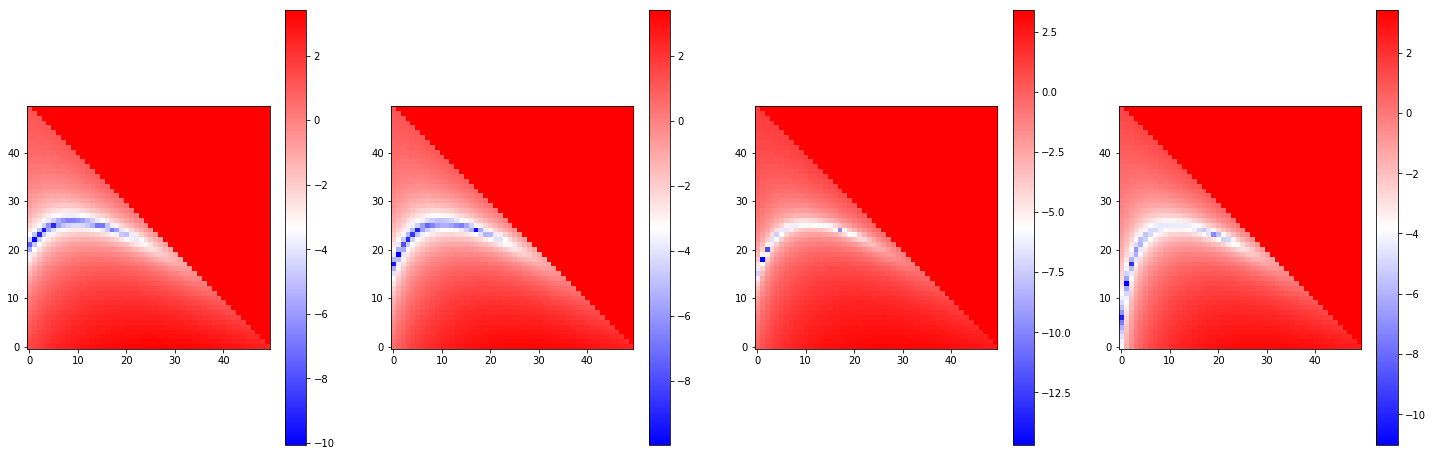

In [91]:
# iter acc values
acc = [14,108,206,600]

#plot accepted values
fig = plt.figure(figsize=(25,8))
ind = 1

for i in range(1,len(diff)+1):
    ax = fig.add_subplot(1,len(diff),ind)
    plt.imshow(np.log(diff[i]['dk']+diff[i]['dkp']+diff[i]['dkpp']), cmap = 'bwr', origin = 'lower')
    plt.colorbar()
    ind = ind + 1
    print params['c1'][acc[i-1]], params['c2'][acc[i-1]]
    
plt.show()

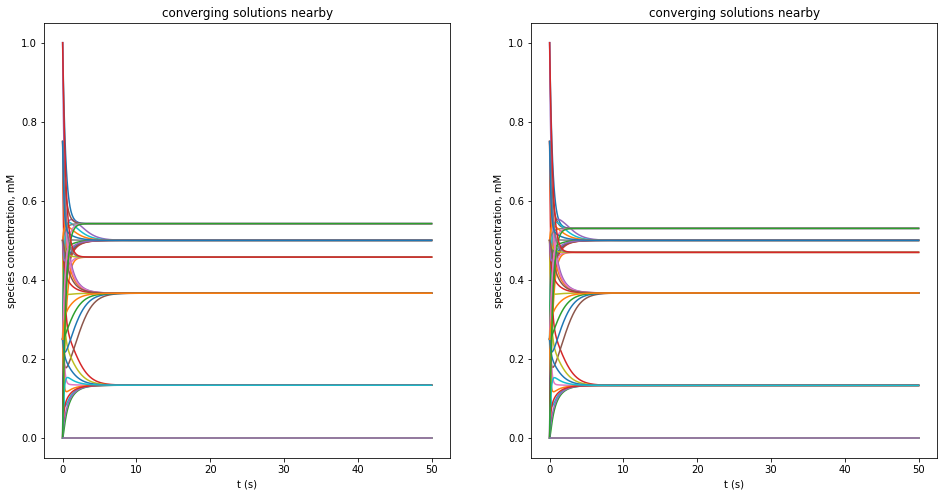

In [118]:
### see if kp, kpp combinations close to stable solution converge to stable solution
fig = plt.figure(figsize=(16,8))
S = 10

N = 1000
t = np.linspace(0,50, N)
vals = 10

inits = {}
iter = 0
Kp = np.linspace(0,1,5)
Kpp = Kp
for i in range(len(Kp)):
    for j in range(len(Kpp)):
        K = Ktot - Kp[i] - Kpp[j]
        if K >= 0:
            inits[iter] = [Ktot - Kp[i] - Kpp[j], Kp[i], Kpp[j]]
            iter = iter + 1

for iter in range(1, len(acc)-1):
    ode = {}
    for i in inits.keys():
        y0 = inits[i]
        paramsTemp = [params['c0'][iter], params['c1'][iter], params['c2'][iter], params['c3'][iter], params['c4'][iter], S, P]
        odeTemp = snt.odeint(rates, y0,t, args = tuple(paramsTemp))
        ode[i] = []
        ode[i] = odeTemp
        
    ax = fig.add_subplot(1,2,iter)
    for i in ode.keys():
        for j in range(np.shape(ode[i])[1]):
            plt.plot(t, ode[i][:,j][0:N])
    ax.set_xlabel('t (s)')
    plt.title('converging solutions nearby')
    ax.set_ylabel('species concentration, mM')


plt.show()

0.1 0.0505050505051 0.0 5.0 5.0


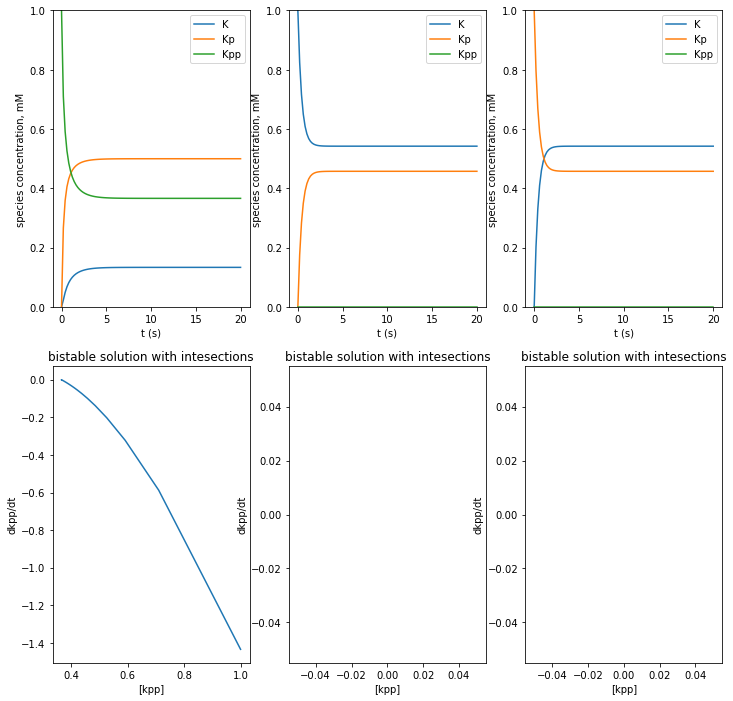

In [124]:
T = 20
att = 1

print params['c0'][att], params['c1'][att], params['c2'][att], params['c3'][att], params['c4'][att]
#initial concentrations
s2 = 0
s3 = 0
s4 = Ktot

V =1
y0 = np.asarray([s2, s3, s4])/V #initial species concentration

n = 100
t = np.linspace(0,T,n)
ode = snt.odeint(rates, y0,t, args = (params['c0'][att], params['c1'][att], params['c2'][att], params['c3'][att], params['c4'][att], S, P))

#find dkpp/dt
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,3,4)
dkpp = np.diff(ode[:,2])/np.diff(t)
ax.plot(ode[:,2][0:n-1],dkpp)
ax.set_title('bistable solution with intesections')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')


ax = fig.add_subplot(2,3,1)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['K', 'Kp', 'Kpp'])
ax.set_ylim([0,Ktot])

# plot another solution
#initial concentrations
s2 = Ktot 
s3 = 0
s4 = 0

V =1
y0 = np.asarray([s2, s3, s4])/V #initial species concentration

n = 100
t = np.linspace(0,T,n)
ode = snt.odeint(rates, y0,t, args = (params['c0'][att], params['c1'][att], params['c2'][att], params['c3'][att], params['c4'][att], S, P))

#find dkpp/dt
ax = fig.add_subplot(2,3,5)
dkpp = np.diff(ode[:,2])/np.diff(t)
ax.plot(ode[:,2][0:n-1],dkpp)
ax.set_title('bistable solution with intesections')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')


ax = fig.add_subplot(2,3,2)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['K', 'Kp', 'Kpp'])
ax.set_ylim([0,Ktot])

# plot another solution
#initial concentrations
s2 = 0 
s3 = Ktot 
s4 = 0

V =1
y0 = np.asarray([s2, s3, s4])/V #initial species concentration

n = 100
t = np.linspace(0,T,n)
ode = snt.odeint(rates, y0,t, args = (params['c0'][att], params['c1'][att], params['c2'][att], params['c3'][att], params['c4'][att], S, P))

#find dkpp/dt
ax = fig.add_subplot(2,3,6)
dkpp = np.diff(ode[:,2])/np.diff(t)
ax.plot(ode[:,2][0:n-1],dkpp)
ax.set_title('bistable solution with intesections')
ax.set_xlabel('[kpp]')
ax.set_ylabel('dkpp/dt')


ax = fig.add_subplot(2,3,3)
for i in range(len(y0)):
    ax.plot(t, ode[:,i][0:n])
ax.set_xlabel('t (s)')
#plt.title(''.join(['[S] = ', str(c1)]))
ax.set_ylabel('species concentration, mM')
ax.legend(['K', 'Kp', 'Kpp'])
ax.set_ylim([0,Ktot])


plt.show()